# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [1]:
import nltk
import requests
import json
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
countries_2 = ['ca', 'us','gb','au','ie','nz']
app_ids = ['553834731','547702041','284882215','333903271']
dict_app_ids_VR = {'553834731':[], '547702041':[],'284882215':[],'333903271':[]}

for i in range(1,11):
    for country in countries_2:
        for app_id in app_ids:
            JSONContent1 = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={app_id}/page={str(i)}/sortby=mostrecent/json").json()
            dict_app_ids_VR[app_id] = dict_app_ids_VR.get(app_id,[])
            for entry in enumerate(JSONContent1['feed']['entry']):
                obj = {'id': app_id, 'review': entry[1]['content']['label'], 'countryCode': country, 'rating':entry[1]['im:rating']['label'],'page':i}
                dict_app_ids_VR[app_id].append(obj)

In [3]:
candy_crush = pd.DataFrame.from_dict(dict_app_ids_VR['553834731'])
tinder = pd.DataFrame.from_dict(dict_app_ids_VR['547702041'])
facebook = pd.DataFrame.from_dict(dict_app_ids_VR['284882215'])
twitter = pd.DataFrame.from_dict(dict_app_ids_VR['333903271'])

df = pd.concat([candy_crush,tinder,facebook,twitter],axis = 0)
df.reset_index(inplace=True,drop=True)

df.head()

,id,review,countryCode,rating,page
0,553834731,"Due to, being unable to open the app (for two ...",ca,1,1
1,553834731,Why are there lives? I hate the time bombs. Pl...,ca,4,1
2,553834731,Asks for way to much info and invades basic hu...,ca,2,1
3,553834731,The lands are beautiful and the levels are the...,ca,5,1
4,553834731,Swipe away with stress and frustration!\n\n Th...,ca,1,1


In [4]:
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def words_analyze(content):
    
    words = [char for char in content if char not in string.punctuation]
    
    words = ''.join(content)
    
    
    return [word for word in words.split() if word.lower() not in stopwords.words('english')]# if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pchiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

review_train, review_test, rating_train, rating_test = train_test_split(df['review'], df['rating'], test_size=0.3)

In [7]:
pipeline = Pipeline([('Bag of Words',CountVectorizer(analyzer=words_analyze)),
                     #('Tfidf',TfidfTransformer()),
                     ('classifier', MultinomialNB())])

In [8]:
pipeline.fit(review_train,rating_train)
prediction = pipeline.predict(review_test)

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [10]:
#1.1
accuracy_score(rating_test,prediction)

0.66

In [11]:
data = pd.concat((twitter, candy_crush, facebook, tinder))

In [12]:
import gensim
data.review = data.review.astype(str)
data.review = [x.lower() for x in data.review]
words = data.review.str.split()

words = pd.DataFrame(words.tolist())
words.head()

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,people,needs,to,give,more,respect,to,each,order,if,...,None,None,None,None,None,None,None,None,None,None
1,i,got,to,right,to,my,fav,youtubers,and,some,...,None,None,None,None,None,None,None,None,None,None
2,people,will,literally,post,child,porn,and,be,fine,but,...,None,None,None,None,None,None,None,None,None,None
3,took,me,over,an,hour,to,figure,out,the,name,...,None,None,None,None,None,None,None,None,None,None
4,not,a,fan,of,controlling,what,can,and,can’t,be,...,None,None,None,None,None,None,None,None,None,None


In [13]:
import re
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})
rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]
words = data.review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [14]:
import gensim.downloader as model_api
word_vectors = model_api.load("glove-wiki-gigaword-50")
# words.columns = words.columns.astype(str)
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))

In [15]:
emb = emb.fillna(0)
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Normalizer,StandardScaler
X = Normalizer().fit_transform(emb) #Normalizer gives better score
sgdr = SGDRegressor()
sgdr.fit(X, data['rating'])
data['gensim'] = sgdr.predict(X)

#1.2
sgdr.score(X, data['rating'])

0.34625291675238734

In [16]:
import sklearn as sk
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
import sklearn.feature_extraction.text as text
import scipy as sc

In [18]:
#1.3
tf = text.TfidfVectorizer()

X = tf.fit_transform(df['review'])
y = df['rating']

Xd = X.toarray()

Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].astype(int).values

In [19]:
#1.4
X_train, X_test, y_train, y_test = train_test_split(Xd, y, test_size=0.15, random_state=42)

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=300, learning_rate=1)

ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=300)

In [20]:
from sklearn.metrics import r2_score
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.4900875443252124


In [21]:
predict1 = ada.predict(X_test)
print("OLS R^2: ", r2_score(y_test,predict1))
accuracy_score(y_test,predict1)

OLS R^2:  0.21684160237506866


0.6472222222222223

In [22]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=300, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
print("OLS R^2: ", r2_score(y_test,pred_rf))
accuracy_score(y_test,pred_rf)

OLS R^2:  -0.42811237213958075


0.5861111111111111

In [23]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(X_train, y_train)
pred_nn = NN.predict(X_test)
accuracy_score(y_test,pred_nn)

0.5494444444444444

In [24]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
pred_svm = SVM.predict(X_test)
print("OLS R^2: ", r2_score(y_test,pred_svm))
accuracy_score(y_test,pred_svm)

OLS R^2:  0.06328113225253307


0.6688888888888889

In [25]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
pred_lr = LR.predict(X_test)
print("OLS R^2: ", r2_score(y_test,pred_lr))
accuracy_score(y_test,pred_lr)

OLS R^2:  -0.6267930791623182


0.5516666666666666

In [29]:
import xgboost as xgb


xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds_xg = xg_reg.predict(X_test)

[19:54:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
print("OLS R^2: ", r2_score(y_test,preds_xg))

OLS R^2:  0.14024885444098278


array([2.619873 , 1.1079427, 3.1131518, ..., 1.2253574, 1.598705 ,
       1.3432497], dtype=float32)

The classification model SVM is doing fairly well at .685556 compared to other classification models AdaBoostClassifier(.648889), MLP classifier(.558889),Logistics Regression(.562222), and Random Forest Classifier(.587222).
The more data we have, the more accurate y becomes. Depending on the classication modelsis looking and what person , some are better to predict a 5 point rating scale. SVM and AdaBoostClassifier are the top 2 for accuracy score.

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [33]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

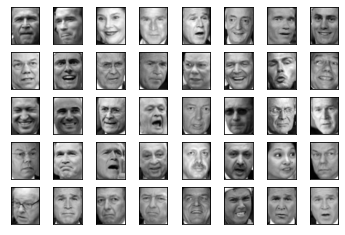

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(5,8, subplot_kw=dict(xticks=[], yticks=[]))
for i, a in enumerate(ax.flat):
    a.imshow(faces.images[i], cmap='gray')

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
scaler.fit(faces['data'])

StandardScaler()

In [37]:
scaled_data = scaler.transform(faces['data'])

In [40]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

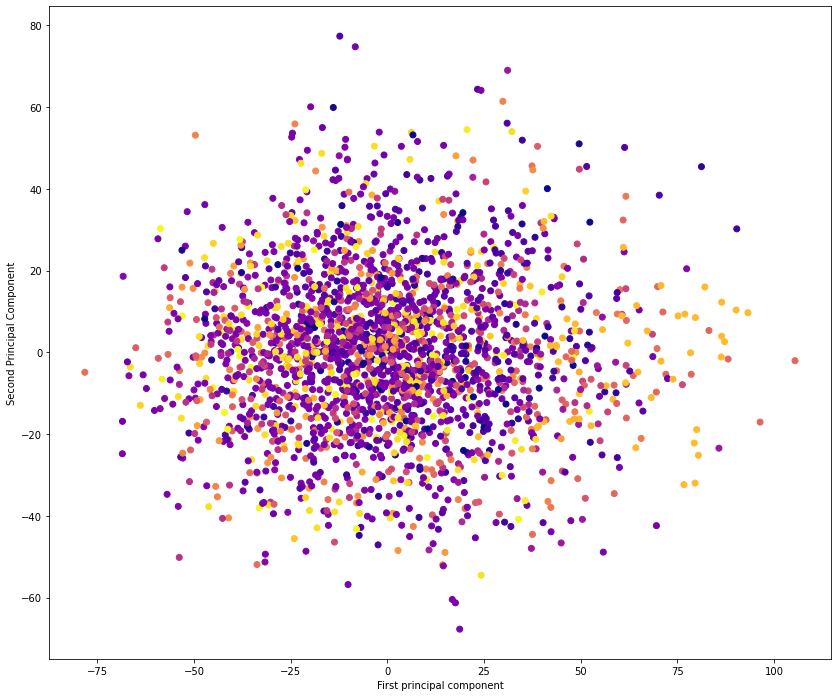

In [41]:
plt.figure(figsize=(14,12))
plt.scatter(x_pca[:,0],x_pca[:,1],c=faces['target'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

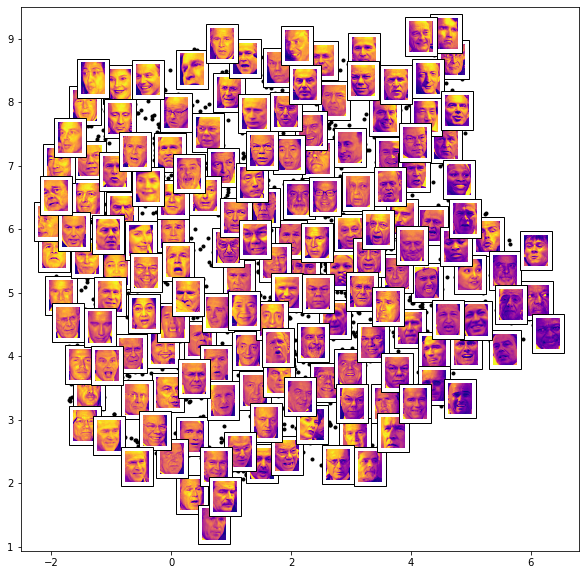

In [44]:
from sklearn.manifold import Isomap
import umap

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

# Choose 1/4 of the "1" digits to project
#data = faces.data[faces.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images[:,::2,::2],
                ax=ax, thumb_frac=0.05,cmap='plasma')